In [1]:
import h5py
f = h5py.File("gifs_curobo/mujoco.hdf5", "r", swmr=True)

In [2]:
f["data"]["demo_0"]["actions"].keys(), f["data"]["demo_0"]["observations"].keys()


(<KeysViewHDF5 ['gripper_pos', 'joint_pos']>,
 <KeysViewHDF5 ['obj_pose', 'qpos', 'rgb']>)

In [3]:
f["data"]["demo_0"]["actions"]['gripper_pos'].shape, f["data"]["demo_0"]["observations"]["rgb"].shape

((62,), (62, 480, 480, 3))

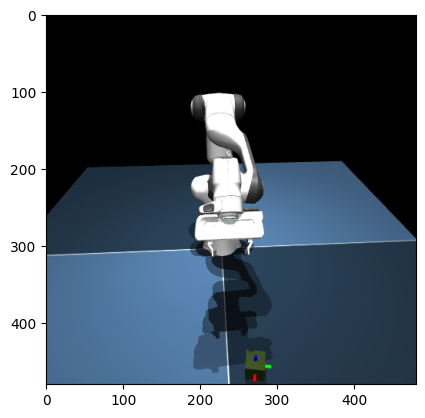

In [5]:
imgs = f["data"]["demo_0"]["observations"]["rgb"]
img = imgs[1]
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()


In [4]:
# save using imageio
import imageio
imgs = f["data"]["demo_0"]["observations"]["rgb"]
imageio.mimsave("tmp.gif", imgs)